In [ ]:
import os, re
import numpy as np
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix

root = "./data"
counts = os.path.join(root, "GSE282059_2B_FFPE_exprMat_file.csv.gz")
meta   = os.path.join(root, "GSE282059_2B_FFPE_metadata_file.csv")
fovpos = os.path.join(root, "GSE282059_2B_FFPE_fov_positions_file.csv")  # optional



import numpy as np
from scipy import sparse


# --- Read metadata (lightweight) ---
obs = pd.read_csv(meta, low_memory=False)
# ensure string/categorical dtypes to save RAM
for c in ["fov", "cell_ID"]:
    if c in obs: obs[c] = obs[c].astype("int32")
obs.index = obs.get("cell_ID_str", pd.Index(obs.index.astype(str)))  # adjust if your file already has an ID

# Many CosMx flat files don't ship an ID string; synthesize one deterministic:
if "cell_ID_str" not in obs:
    if {"fov","cell_ID"}.issubset(obs.columns):
        obs.index = [f"c_{f}_{cid}" for f, cid in zip(obs["fov"], obs["cell_ID"])]
    else:
        obs.index = obs.index.astype(str)

# --- Read expression (sparse) ---
# 1) load; drop annotation cols; keep RNA probes (drop Negative/SystemControl if present)
df = pd.read_csv(counts, low_memory=False)
if {"fov","cell_ID"}.issubset(df.columns):
    df["cell_ID_str"] = [f"c_{f}_{cid}" for f, cid in zip(df["fov"], df["cell_ID"])]
    df.set_index("cell_ID_str", inplace=True)
    df.drop(columns=["fov","cell_ID"], inplace=True, errors="ignore")

dummy = re.compile(r"Negative|SystemControl|NegPrb|FalseCode", re.IGNORECASE)
genes = [g for g in df.columns if not dummy.search(g)]

chunksize = 1000
it = pd.read_csv(counts, chunksize=chunksize, low_memory=False)
genes, data, rows, cols, cell_ids = None, [], [], [], []
r0 = 0
for ch in it:
    if {"fov","cell_ID"}.issubset(ch.columns):
        ch["cell_ID_str"] = [f"c_{f}_{cid}" for f, cid in zip(ch["fov"], ch["cell_ID"])]
    ch.set_index("cell_ID_str", inplace=True)
    ch = ch.drop(columns=["fov","cell_ID"], errors="ignore")
    g_now = [g for g in ch.columns if not dummy.search(g)]
    if genes is None: genes = g_now
    vals = ch[genes].to_numpy(dtype=np.float32, copy=False)
    r,c = np.nonzero(vals)
    rows.append(r + r0); cols.append(c); data.append(vals[r, c])
    cell_ids.extend(ch.index.tolist())
    r0 += vals.shape[0]
coo = sparse.coo_matrix((np.concatenate(data), (np.concatenate(rows), np.concatenate(cols))),
                        shape=(r0, len(genes)))
X = coo.tocsr()
adata = ad.AnnData(X=X, obs=obs.loc[cell_ids], var=pd.DataFrame(index=pd.Index(genes, name="gene")))


In [ ]:
import squidpy as sq

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
adata = sc.read('cosmx.h5ad')

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [3]:
import re
import json
import numpy as np
import pandas as pd

UUID_DOTTED = re.compile(
    r"(?:[0-9a-fA-F]{8}(?:[._-][0-9a-fA-F]{4}){3}[._-][0-9a-fA-F]{12})"
)

CANON_MAP = {
    # coordenadas
    "centerx_local_px": "x_local_px",
    "centery_local_px": "y_local_px",
    "centerx_global_px": "x_global_px",
    "centery_global_px": "y_global_px",
    # ids
    "cell": "cell_id",
    "cellid": "cell_id",
    "cell_id": "cell_id",
    "fov_id": "fov",
    "fovid": "fov",
    "fovindex": "fov",
    "fov_index": "fov",
    # miscelánea útil
    "run_tissue_name": "tissue",
    "slide_id": "slide_id",
}

def _strip_uuid_tokens(name: str) -> str:
    # elimina cadenas tipo GUID separadas por puntos/guiones
    return UUID_DOTTED.sub("", name)

def _basic_slug(name: str) -> str:
    # minúsculas, no alfanum → _, colapsar _, recortar _
    s = name.lower()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^0-9a-z_]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s

def _apply_canon_map(slug: str) -> str:
    # mapea exactos; si no, intenta por heurística en coordenadas
    if slug in CANON_MAP:
        return CANON_MAP[slug]
    # heurísticas: mean/max.<marker> ya vienen como mean_panck → ok
    return slug

def clean_obs_columns(obs: pd.DataFrame, save_map: str = None) -> pd.DataFrame:
    orig_cols = list(obs.columns)
    cleaned = []
    mapping = {}

    # 1) limpiar uno a uno
    for c in orig_cols:
        s = c.strip()
        s = _strip_uuid_tokens(s)              # fuera GUIDs/largos hashes
        s = _basic_slug(s)                     # slug
        s = _apply_canon_map(s)                # canon
        cleaned.append(s)

    # 2) asegurar unicidad: si colisiona, añade sufijo _1, _2, ...
    seen = {}
    unique_cols = []
    for s in cleaned:
        if s not in seen:
            seen[s] = 0
            unique_cols.append(s)
        else:
            seen[s] += 1
            unique_cols.append(f"{s}_{seen[s]}")

    # 3) construir mapeo y renombrar
    mapping = dict(zip(orig_cols, unique_cols))
    obs2 = obs.rename(columns=mapping)

    # 4) normalizar tipos de fov/cell_id si existen
    for k in ("fov", "cell_id"):
        if k in obs2.columns:
            # usa enteros “blandos” (pueden contener NA)
            obs2[k] = pd.to_numeric(obs2[k], errors="coerce").astype("Int64")

    # 5) opcional: guardar el mapeo para trazabilidad
    if save_map is not None:
        with open(save_map, "w") as fh:
            json.dump(mapping, fh, indent=2)

    return obs2, mapping

# ---------- USO CON ANNDATA ----------
# adata.obs = adata.obs.copy()  # si quieres evitar view warnings
adata.obs, colmap = clean_obs_columns(adata.obs, save_map="obs_colmap.json")

# crea coordenadas en .obsm si están disponibles
if {"x_local_px", "y_local_px"}.issubset(adata.obs.columns):
    adata.obsm["spatial"] = adata.obs[["x_local_px", "y_local_px"]].to_numpy()

if {"x_global_px", "y_global_px"}.issubset(adata.obs.columns):
    adata.obsm["spatial_fov"] = adata.obs[["x_global_px", "y_global_px"]].to_numpy()

print("Columns cleaned. Example mapping (first 10):",
      dict(list(colmap.items())[:10]))

Columns cleaned. Example mapping (first 10): {'RNA_nbclust_e2437845.a0cf.474d.961f.771e6f80fc02_1_clusters': 'rna_nbclust_1_clusters', 'RNA_nbclust_e2437845.a0cf.474d.961f.771e6f80fc02_1_posterior_probability': 'rna_nbclust_1_posterior_probability', 'fov': 'fov', 'Area': 'area', 'AspectRatio': 'aspectratio', 'Width': 'width', 'Height': 'height', 'Mean.PanCK': 'mean_panck', 'Max.PanCK': 'max_panck', 'Mean.CD68': 'mean_cd68'}


In [5]:
adata.layers['counts'] = adata.X.copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [83]:
import numpy as np
import pandas as pd
def score_signature(adata, genes, name, ctrl_size=50, seed=0):
    """Rank-based gene set scoring with Scanpy's score_genes."""
    genes = [g for g in genes if g in adata.var_names]
    if len(genes) == 0:
        adata.obs[name] = np.nan
        return
    sc.tl.score_genes(adata, gene_list=genes, ctrl_size=ctrl_size,
                      score_name=name, random_state=seed)


def zscore_inplace(adata, cols):
    for c in cols:
        x = adata.obs[c].values.astype(float)
        mu, sd = np.nanmean(x), np.nanstd(x) + 1e-8
        adata.obs[f"z_{c}"] = (x - mu) / sd

def _safe_get_z(adata, key):
    x = pd.to_numeric(adata.obs.get(f"z_{key}", np.nan), errors="coerce").to_numpy()
    return np.where(np.isfinite(x), x, np.nan)

def _sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))
def hierarchical_score(
    adata,
    sub_genes,
    parent_genes,
    sibling_gene_sets,
    gamma=0.5,
    delta=1.0,
    seed=0,
    mode="soft",           
    parent_q=0.80,         
    k=3.0,                 
    out_key="substate_hier_score",
    residualize=True       
):
    # 1) Score raw
    score_signature(adata, sub_genes,    "score_sub",    seed=seed)
    score_signature(adata, parent_genes, "score_parent", seed=seed)

    sib_cols = []
    for i, gs in enumerate(sibling_gene_sets or []):
        nm = f"score_sib{i}"
        score_signature(adata, gs, nm, seed=seed)
        sib_cols.append(nm)

    # 2) Z-score
    cols = ["score_sub", "score_parent"] + sib_cols
    zscore_inplace(adata, cols)

    z_sub    = _safe_get_z(adata, "score_sub")
    z_parent = _safe_get_z(adata, "score_parent")

    # 3) Residualize sub on parent (optional)
    if residualize:
        vp = np.nanvar(z_parent) + 1e-8
        cov = np.nanmean((z_sub - np.nanmean(z_sub)) * (z_parent - np.nanmean(z_parent)))
        beta = cov / vp
        z_sub_adj = z_sub - beta * z_parent
    else:
        z_sub_adj = z_sub

    # 4) Sibling suppression (max)
    if sib_cols:
        z_sib_max = np.nanmax(
            np.vstack([_safe_get_z(adata, c) for c in sib_cols]),
            axis=0
        )
    else:
        z_sib_max = 0.0

    # 5) Parent gate
    if mode == "hard":
        thr = np.nanquantile(z_parent, parent_q)
        gate = (z_parent >= thr).astype(float)
    elif mode == "soft":
        thr = np.nanquantile(z_parent, parent_q)
        gate = _sigmoid(k * (z_parent - thr))
    else:  # "none"
        gate = 1.0

    # 6) Final hierarchical score (🔹 subtract only if sibling > 0)
    # z_sib_max_pos = np.maximum(, 0.0)
    score = gate * (z_sub_adj + gamma * z_parent) - delta * z_sib_max
    adata.obs[out_key] = score

    return adata


# (A) Fibroblasts (pan-fibro)
FB_CORE = [
    "COL1A1","COL1A2","COL3A1","DCN","LUM","DPT","BGN","FBLN1","FN1","PDGFRA","THY1","COL6A1","COL6A3","COL5A1"
]
EPI_ALL = ["EPCAM","TACSTD2","KRT8","KRT18","KRT19","KRT7","MUC1","CLDN4","CLDN7"]

SIG_NORM = ['DCN','PDGFRA','TIMP1','CFD']
SIG_ATAL = ['WFDC2','B2M','TMSB10','CLU','TACSTD2'] # aTAL1_0
SIG_TAL_CORE = [
         # calcium-sensing receptor (apical)
]
epi_sibiling =  [
    [
        "SLC34A1", "SLC5A2", "AQP1", "LRP2", "CUBN",
        "PDZK1", "ALDOB", "ENPEP", "CDH6", "LTC4S",
        "SLC22A6", "SLC22A8", "SLC47A1", "DPEP1",
        "ANPEP", "MIOX"
    ],

]

# Extended (often TAL-enriched; helpful for robustness across donors/platforms)
SIG_TAL_EXTENDED = [ "UMOD",        # uromodulin
    "SLC12A1",     # NKCC2 (apical Na-K-2Cl cotransporter)
    "KCNJ1",       # ROMK (apical K+ channel)
    "CLCNKB",      # basolateral Cl- channel
    "BSND",        # barttin (CLCNKB subunit)
    "CLDN16",      # tight junction, Mg2+/Ca2+ paracellular
    "CLDN19",      # tight junction partner of CLDN16
    "CASR",  
    "HNF1B",       # TF; TAL/DCT lineage
    "POU3F3",      # BRN1; cortical TAL/DCT lineage
    "KRT8", "KRT18", "MUC1"  # epithelial reinforcement (already in EPI_ALL but ok for scoring stability)
]
pt_genes = [
    "SLC34A1", "SLC5A2", "AQP1", "LRP2", "CUBN",
    "PDZK1", "ALDOB", "ENPEP", "CDH6", "LTC4S",
    "SLC22A6", "SLC22A8", "SLC47A1", "DPEP1",
    "ANPEP", "MIOX"
]

hierarchical_score(adata, SIG_NORM, FB_CORE, [])
adata.obs["sig_NORN_hier"] = adata.obs["substate_hier_score"]
hierarchical_score(adata, SIG_ATAL, SIG_TAL_EXTENDED, epi_sibiling)
adata.obs["sig_aTAL1_0_hier"] = adata.obs["substate_hier_score"]

In [14]:
adata.write('data/cosmx_processed.h5ad', compression='gzip')

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (7,7)

import random
# import tensorflow as tf

# seed = 42

import os, re
import numpy as np
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix
# random.seed(seed)

In [2]:
adata = sc.read('data/cosmx_processed.h5ad', compression='gzip')

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [3]:
adata.obs.index = adata.obs['cell_id_1']

In [4]:
meta = pd.read_csv('metadata_cosmx6k.csv', index_col=0)


In [5]:
meta

,cell_ID,fov,Area,sample_ID,sample_date,Condition,x_coord,y_coord,Mean.PanCK,Max.PanCK,...,Area.um2,complexity,n.Transcripts,n.Genes,nCount_RNA,nFeature_RNA,Annotation.Lvl1,Annotation.Lvl2,InjuryState,Niche
c_2_100_10,c_2_100_10,100,5585,UUO5,16/01/23,UUO,10.781644,17.528931,1268,6436,...,80.801020,1.532773,912,595,891,576,Border Region,Border Region,Border Region,Border Region
c_2_100_1000,c_2_100_1000,100,5347,UUO5,16/01/23,UUO,10.764684,17.182522,889,1932,...,77.357753,1.524064,285,187,280,182,B Cell,B Cell,Other,Fibrotic Niche
c_2_100_1001,c_2_100_1001,100,3617,UUO5,16/01/23,UUO,10.795235,17.182281,1350,4036,...,52.328968,1.277778,138,108,135,105,T Cell,NK Cell,Other,Fibrotic Niche
c_2_100_1002,c_2_100_1002,100,3517,UUO5,16/01/23,UUO,10.604470,17.183484,572,1400,...,50.882218,1.415385,276,195,271,190,Border Region,Border Region,Border Region,Border Region
c_2_100_1003,c_2_100_1003,100,4985,UUO5,16/01/23,UUO,10.401315,17.182883,946,1808,...,72.120516,1.227545,205,167,202,164,Border Region,Border Region,Border Region,Border Region
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_2_96_733,c_2_96_733,96,4724,UUO3,10/11/22,UUO,8.608795,12.992285,589,3276,...,68.344497,1.544872,482,312,471,302,Fibroblast,Myofibroblast,Myofibroblast,Fibrotic Niche
c_2_97_785,c_2_97_785,97,5532,UUO5,16/01/23,UUO,11.318457,17.562730,321,1012,...,80.034242,1.525000,427,280,420,273,Fibroblast,Fibroblast,Other,Injured Epithelia
c_2_9_1022,c_2_9_1022,9,4088,UUO4,22/12/22,UUO,0.721686,15.627098,8143,61376,...,59.143163,1.460759,577,395,571,389,Endothelia,Endothelia,Other,Fibrotic Niche
c_2_9_1601,c_2_9_1601,9,4722,UUO4,22/12/22,UUO,0.786397,15.485647,107,1152,...,68.315562,1.411504,319,226,313,220,Fibroblast,Myofibroblast,Myofibroblast,Fibrotic Niche


In [6]:
meta = meta.loc[adata.obs.index]
adata.obs['celltype_l1'] = meta['Annotation.Lvl1']
adata.obs['celltype_l2'] = meta['Annotation.Lvl2']

adata.obs['state'] = meta['InjuryState']
adata.obs['niche'] = meta['Niche']
adata.obs['sample_ID'] = meta['sample_ID']


In [7]:
emb = pd.read_csv('cell_embeddings_cosmx6k.csv', index_col=0)
emb = emb.loc[adata.obs.index]
emb
adata.obsm['X_umap'] = emb.values

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


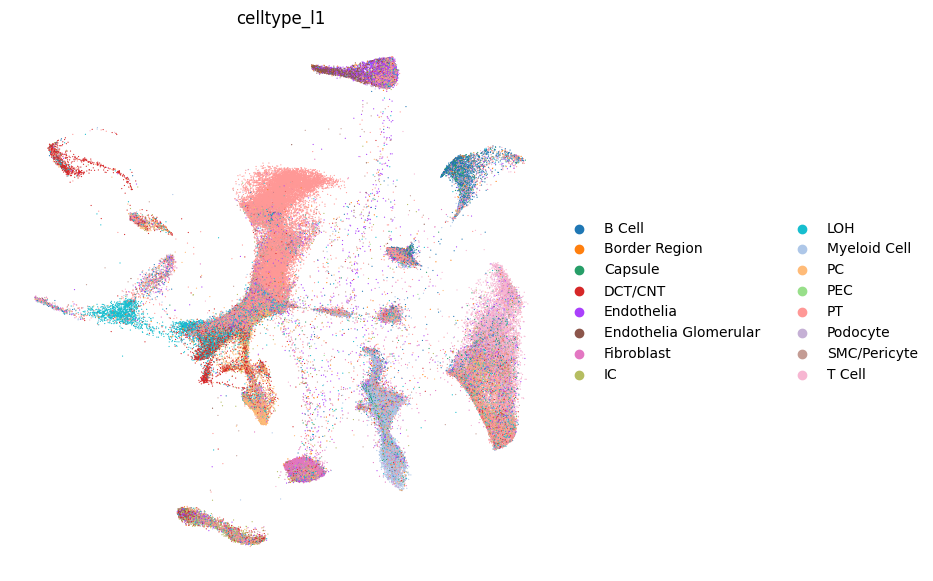

In [8]:
sc.pl.umap(adata, color = 'celltype_l1', frameon=False, size=3, show=False)
plt.savefig(f'figs/umaps_ct_l1.png', dpi=400, bbox_inches='tight')

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


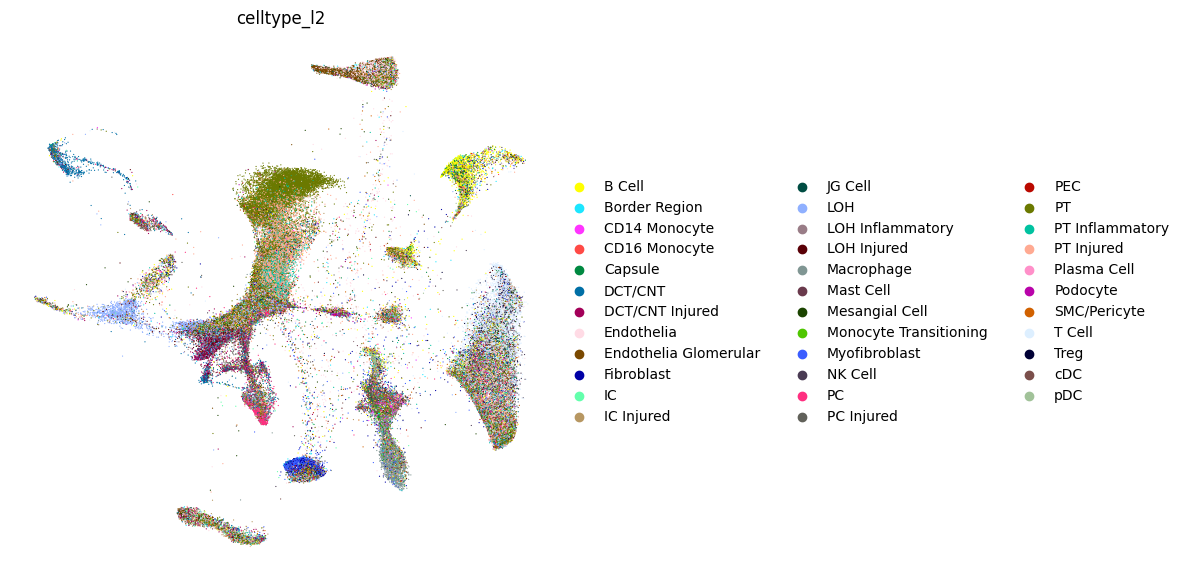

In [9]:
sc.pl.umap(adata, color = 'celltype_l2', frameon=False, size=3, show=False)
plt.savefig(f'figs/umaps_ct_l2.png', dpi=400, bbox_inches='tight')

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


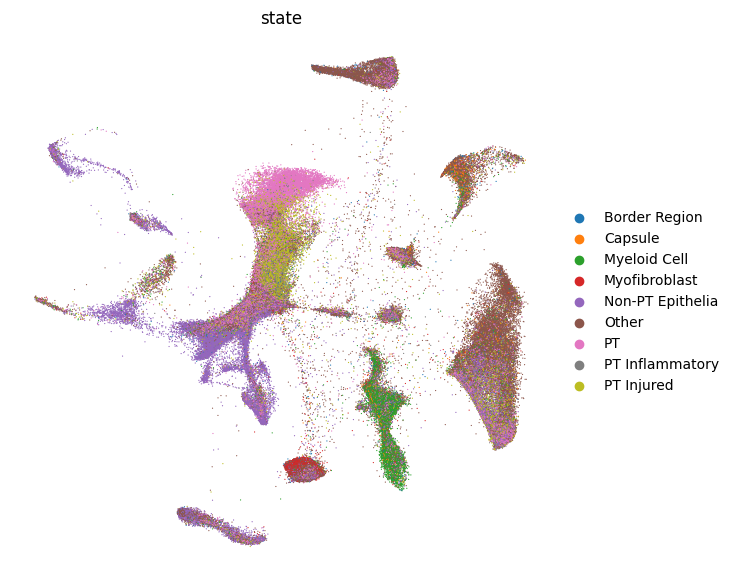

In [10]:
sc.pl.umap(adata, color = 'state', frameon=False, size=3, show=False)
plt.savefig(f'figs/umaps_state.png', dpi=400, bbox_inches='tight')

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


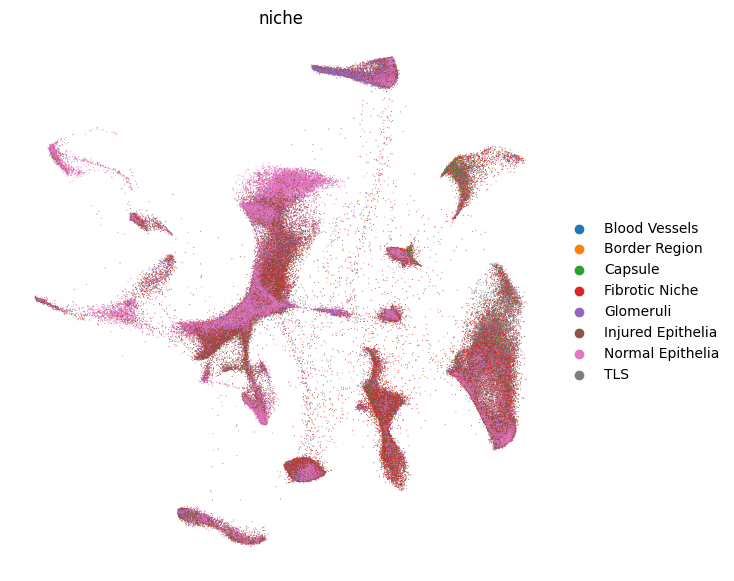

In [11]:
sc.pl.umap(adata, color = 'niche', frameon=False, size=2, show=False)
plt.savefig(f'figs/umaps_niche.png', dpi=400, bbox_inches='tight')

In [131]:
palette =  {'B Cell': '#1f77b4',
 'Border Region': '#ff7f0e',
 'Capsule': '#279e68',
 'NORN': '#d62728',
 'Endothelia': '#aa40fc',
 'Endothelia Glomerular': '#8c564b',
 'Fibroblast': '#e377c2',
 'IC': '#b5bd61',
 'LOH': '#17becf',
 'Myeloid Cell': '#aec7e8',
 'DCT/CNT': "#3D30FC",
 'PC': "#7fe2c1",
 'PEC': '#ff9896',
 'PT': '#c5b0d5',
 'Podocyte': '#c49c94',
 'SMC/Pericyte': '#f7b6d2',
 'T Cell': '#dbdb8d',
 'aTAL1_0': "#14FF03"}

SAMPLES SELECTION = UUO2

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:28: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]


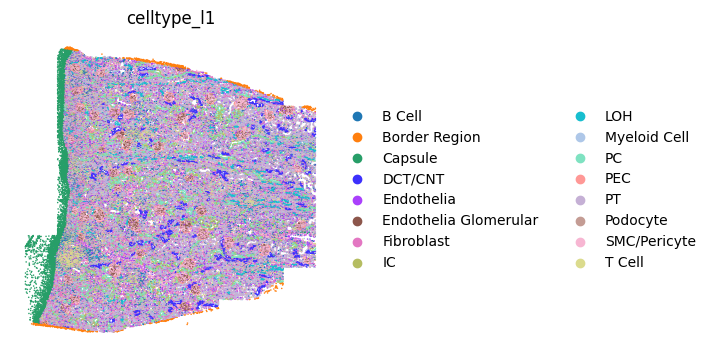

In [22]:
import squidpy as sq
spk='spatial_fov_flat'
key='celltype_l1'
ax = sq.pl.spatial_scatter(adata[adata.obs['sample_ID'].isin(['UUO2'])], color=key, spatial_key=spk,frameon=False, img=False, size=100, return_ax=True)
ax.figure.savefig(f"figs/spatial_full_{key}_sample_UUO2.png", dpi=400, bbox_inches="tight")

In [ ]:
import squidpy as sq
spk='spatial_fov_flat'
key='celltype_l1'
ax = sq.pl.spatial_scatter(adata[adata.obs['fov'].isin([160,161,162,163,164])],frameon=False, color=key, spatial_key=spk, img=False, size=60,figsize=(15,5), return_ax=True)
ax.figure.savefig(f"figs/spatial_full_{key}_sample_UUO2.png", dpi=400, bbox_inches="tight")

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:28: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]


In [44]:
adata.obs['fov'] = adata.obs['fov'].astype(int)

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


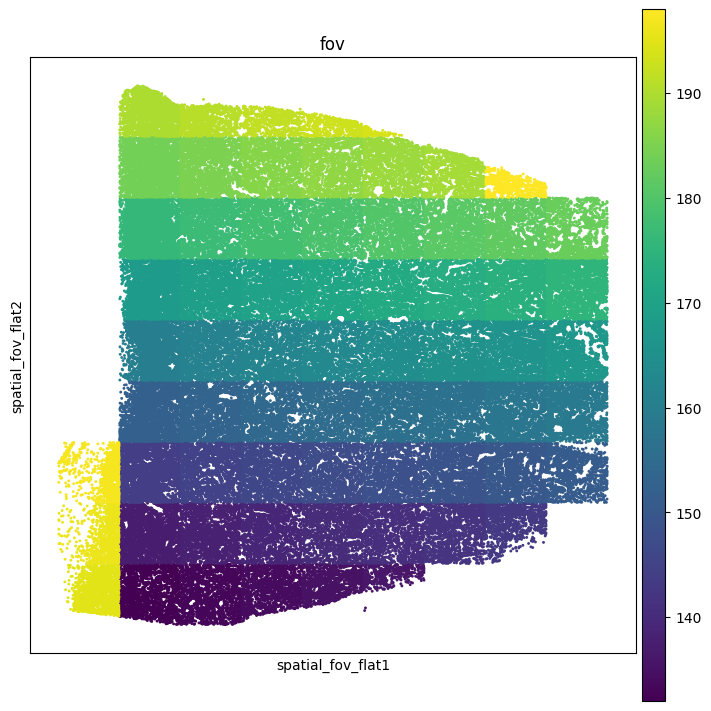

In [45]:
import squidpy as sq
spk='spatial_fov_flat'
key='fov'
ax = sq.pl.spatial_scatter(adata[adata.obs['sample_ID'].isin(['UUO2'])], color=key, spatial_key=spk, img=False, size=100, return_ax=True)
ax.figure.savefig(f"figs/spatial_full_{key}_sample_UUO2.png", dpi=400, bbox_inches="tight")

In [39]:
adata.obs['celltype_l1'].value_counts()

celltype_l1
PT                       128863
Fibroblast                70824
Myeloid Cell              43997
Endothelia                40229
SMC/Pericyte              39287
T Cell                    38495
LOH                       33256
B Cell                    30486
Border Region             20508
PC                        19586
DCT/CNT                   15292
IC                        14115
Capsule                    6903
Endothelia Glomerular      6036
NORN                       5229
PEC                        5057
Podocyte                   4314
aTAL1_0                    1378
Name: count, dtype: int64

# SETTING Quantile 99.5 for Signature-like cells

In [ ]:
adata.obs['NORN_like'] = adata.obs['sig_NORN_hier'] > np.quantile(adata.obs['sig_NORN_hier'], 0.995)
adata.obs['aTAL1_0_like'] = adata.obs['sig_aTAL1_0_hier'] > np.quantile(adata.obs['sig_aTAL1_0_hier'], 0.995)

In [36]:
adata.obs['celltype_l1'] = adata.obs['celltype_l1'].tolist()

In [37]:
adata.obs.loc[adata.obs['NORN_like'],'celltype_l1']='NORN'

In [38]:
adata.obs.loc[adata.obs['aTAL1_0_like'],'celltype_l1']='aTAL1_0'

In [ ]:
import squidpy as sq
spk='spatial_fov_flat'
key='celltype_l1'
ax = sq.pl.spatial_scatter(adata[adata.obs['sample_ID'].isin(['UUO2'])], color=key, spatial_key=spk,frameon=False, img=False, size=100, return_ax=True)
ax.figure.savefig(f"figs/spatial_full_{key}_sample_UUO2.png", dpi=400, bbox_inches="tight")

In [91]:
counts = pd.crosstab(adata.obs['NORN_like'], adata.obs['aTAL1_0_like'])
counts

aTAL1_0_like,False,True
NORN_like,,
False,513416,5200
True,5200,39


In [21]:
# Complete, runnable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# --- 1) Build aligned count table (rows = flags, cols = celltype_l1) ---
def heatmap_crosstab(adata, flag_rows = ["NORN_like", "aTAL1_0_like"],flag_col="celltype_l1",multi=0.7):
    flag_rows = ["NORN_like", "aTAL1_0_like"]

    # Decide a stable column order
    if pd.api.types.is_categorical_dtype(adata.obs[flag_col]):
        col_order = list(adata.obs[flag_col].cat.categories)
    else:
        col_order = sorted(pd.unique(adata.obs[flag_col].dropna()))

    rows = []
    for fc in flag_rows:
        mask = adata.obs[fc].fillna(False).astype(bool)
        vc = adata.obs.loc[mask, flag_col].dropna().value_counts()
        row = pd.Series(0, index=col_order, dtype=int)
        row.loc[vc.index.intersection(col_order)] = vc.values
        row.name = fc
        rows.append(row)

    counts = pd.DataFrame(rows)

    # (Optional) also compute row-wise percentages
    perc = counts.div(counts.sum(axis=1).replace(0, np.nan), axis=0) * 100

    # --- 2) Plot heatmap (counts). Switch to `perc` if you prefer percentages ---
    data_to_plot = counts  # or `perc`
    # Complete, runnable example (drop-in idea for your loop)


    fig, ax = plt.subplots(figsize=(multi*data_to_plot.shape[1], 2.8))
    im = ax.imshow(data_to_plot.values, aspect="auto", cmap='magma')

    ax.set_xticks(np.arange(data_to_plot.shape[1]))
    ax.set_yticks(np.arange(data_to_plot.shape[0]))
    ax.set_xticklabels(data_to_plot.columns, rotation=45, ha="right")
    ax.set_yticklabels(data_to_plot.index)

    # --- Annotate with white outline ---
    for i in range(data_to_plot.shape[0]):
        for j in range(data_to_plot.shape[1]):
            val = data_to_plot.iat[i, j]
            t = ax.text(
                j, i, f"{int(val)}",
                ha="center", va="center",
                color="black", fontweight="bold"
            )
            t.set_path_effects([
                pe.Stroke(linewidth=2.0, foreground="white"),
                pe.Normal(),
            ])

    fig.colorbar(im, ax=ax, label="Cells")
    plt.tight_layout()



In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# --- 1) Build aligned count table (rows = flags, cols = celltype_l1) ---
def heatmap_crosstab(
    adata,
    flag_rows=["NORN_like", "aTAL1_0_like"],
    flag_col="celltype_l1",
    multi=0.7,
    annotate="count"  # "count" | "perc"
):
    # Decide a stable column order
    if pd.api.types.is_categorical_dtype(adata.obs[flag_col]):
        col_order = list(adata.obs[flag_col].cat.categories)
    else:
        col_order = sorted(pd.unique(adata.obs[flag_col].dropna()))

    rows = []
    for fc in flag_rows:
        mask = adata.obs[fc].fillna(False).astype(bool)
        vc = adata.obs.loc[mask, flag_col].dropna().value_counts()
        row = pd.Series(0, index=col_order, dtype=int)
        row.loc[vc.index.intersection(col_order)] = vc.values
        row.name = fc
        rows.append(row)

    counts = pd.DataFrame(rows)

    # --- 2) Compute row-wise percentages ---
    perc = counts.div(counts.sum(axis=1).replace(0, np.nan), axis=0) * 100

    # --- 3) Heatmap: color by percentage ---
    data_to_plot = perc

    fig, ax = plt.subplots(figsize=(multi * data_to_plot.shape[1], 2.8))
    im = ax.imshow(data_to_plot.values, aspect="auto", cmap="magma", vmin=0, vmax=100)

    ax.set_xticks(np.arange(data_to_plot.shape[1]))
    ax.set_yticks(np.arange(data_to_plot.shape[0]))
    ax.set_xticklabels(data_to_plot.columns, rotation=45, ha="right")
    ax.set_yticklabels(data_to_plot.index)

    # --- 4) Annotate ---
    for i in range(data_to_plot.shape[0]):
        for j in range(data_to_plot.shape[1]):
            if annotate == "count":
                val = counts.iat[i, j]
                txt = f"{val:d}"
            else:  # annotate == "perc"
                val = data_to_plot.iat[i, j]
                txt = f"{val:.1f}%"

            t = ax.text(
                j, i, txt,
                ha="center", va="center",
                color="black", fontweight="bold"
            )
            t.set_path_effects([
                pe.Stroke(linewidth=2.0, foreground="white"),
                pe.Normal(),
            ])

    fig.colorbar(im, ax=ax, label="Percentage of cells (%)")
    plt.tight_layout()
    return fig, ax


/tmp/ipykernel_9987/104979149.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(adata.obs[flag_col]):


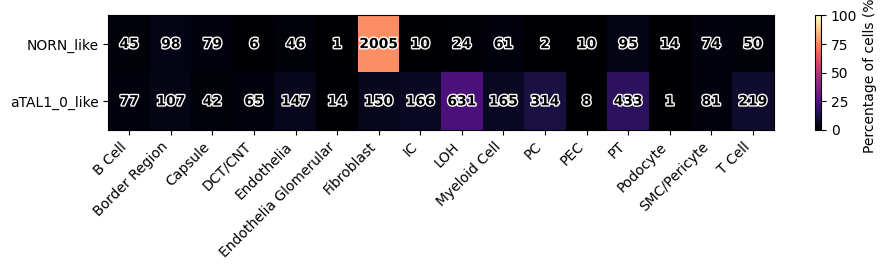

In [100]:
key='celltype_l1'

heatmap_crosstab(adata, flag_rows = ["NORN_like", "aTAL1_0_like"],flag_col=key, multi=0.6 )
plt.savefig(f'figs/heatmap_pops_{key}.png', dpi=400, bbox_inches='tight')

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

def heatmap_crosstab(
    adata,
    flag_rows=["NORN_like", "aTAL1_0_like"],
    flag_col="celltype_l1",
    multi=0.9,
    annotate="count"  # "count" | "perc"
):
    # Stable column order
    if pd.api.types.is_categorical_dtype(adata.obs[flag_col]):
        col_order = list(adata.obs[flag_col].cat.categories)
    else:
        col_order = sorted(pd.unique(adata.obs[flag_col].dropna()))

    rows = []
    for fc in flag_rows:
        mask = adata.obs[fc].fillna(False).astype(bool)
        vc = adata.obs.loc[mask, flag_col].dropna().value_counts()
        row = pd.Series(0, index=col_order, dtype=int)
        row.loc[vc.index.intersection(col_order)] = vc.values
        row.name = fc
        rows.append(row)

    counts = pd.DataFrame(rows)

    # Row-wise percentages
    perc = counts.div(counts.sum(axis=1).replace(0, np.nan), axis=0) * 100

    # 🔹 Rotate 90° → transpose
    counts_T = counts.T
    perc_T = perc.T

    data_to_plot = perc_T  # color by percentage

    fig, ax = plt.subplots(figsize=(multi * data_to_plot.shape[1], 0.5 * data_to_plot.shape[0]))
    im = ax.imshow(data_to_plot.values, aspect="auto", cmap="magma", vmin=0, vmax=100)

    ax.set_xticks(np.arange(data_to_plot.shape[1]))
    ax.set_yticks(np.arange(data_to_plot.shape[0]))
    ax.set_xticklabels(data_to_plot.columns, rotation=45, ha="right")
    ax.set_yticklabels(data_to_plot.index)

    # Annotate
    for i in range(data_to_plot.shape[0]):
        for j in range(data_to_plot.shape[1]):
            if annotate == "count":
                val = counts_T.iat[i, j]
                txt = f"{val:d}"
            else:  # annotate == "perc"
                val = data_to_plot.iat[i, j]
                txt = f"{val:.1f}%"

            t = ax.text(
                j, i, txt,
                ha="center", va="center",
                color="black", fontweight="bold"
            )
            t.set_path_effects([
                pe.Stroke(linewidth=2.0, foreground="white"),
                pe.Normal(),
            ])

    fig.colorbar(im, ax=ax, label="Percentage of cells (%)")
    plt.tight_layout()
    return fig, ax


/tmp/ipykernel_9987/2994839617.py:14: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(adata.obs[flag_col]):
/tmp/ipykernel_9987/2994839617.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


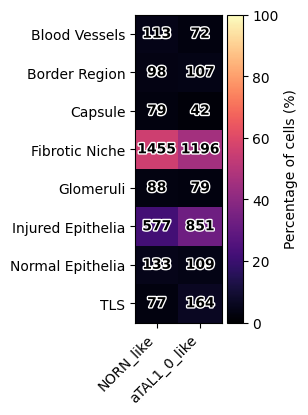

In [111]:
key='niche'

heatmap_crosstab(adata, flag_rows = ["NORN_like", "aTAL1_0_like"],flag_col=key, multi=0.7 )
plt.savefig(f'figs/heatmap_pops_{key}.png', dpi=400, bbox_inches='tight')

In [147]:
adata.obs['celltype_l1'] = adata.obs['celltype_l1'].tolist()

In [148]:
adata.obs.loc[adata.obs['aTAL1_0_like'], 'celltype_l1'] = 'aTAL1_0_like'

In [149]:
adata.obs.loc[adata.obs['NORN_like'], 'celltype_l1'] = 'NORN_like'

In [139]:
palette =  {'B Cell': '#1f77b4',
 'Border Region': '#ff7f0e',
 'Capsule': '#279e68',
 'NORN_like': '#d62728',
 'Endothelia': '#aa40fc',
 'Endothelia Glomerular': '#8c564b',
 'Fibroblast': '#e377c2',
 'IC': '#b5bd61',
 'LOH': '#17becf',
 'Myeloid Cell': '#aec7e8',
 'DCT/CNT': "#3D30FC",
 'PC': "#7fe2c1",
 'PEC': '#ff9896',
 'PT': '#c5b0d5',
 'Podocyte': '#c49c94',
 'SMC/Pericyte': '#f7b6d2',
 'T Cell': '#dbdb8d',
 'aTAL1_0_like': "#14FF03"}

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


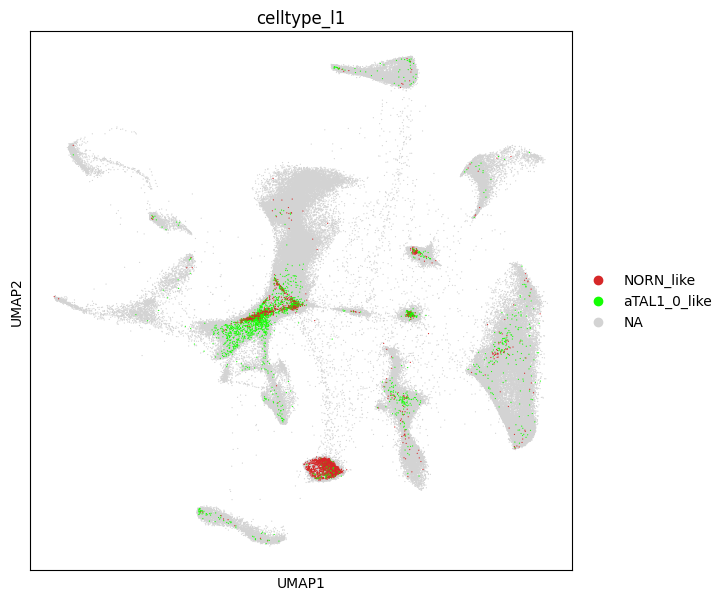

In [154]:
sc.pl.umap(adata, color='celltype_l1', palette=palette, groups = ['NORN_like','aTAL1_0_like'], size=3)

In [118]:
adata.obs['fov'] = adata.obs['fov'].astype(int)

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:28: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]


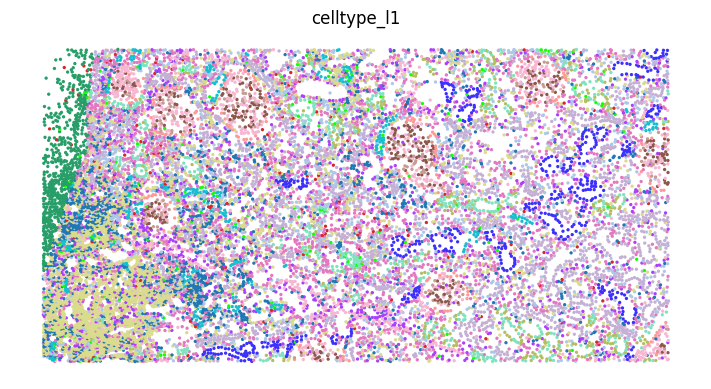

In [164]:
import squidpy as sq
spk='spatial_fov_flat'
key='celltype_l1'
ax = sq.pl.spatial_scatter(adata[adata.obs['fov'].isin([152, 153, 154, 155, 144, 145, 146,147])], legend_loc=None,color=key, spatial_key=spk,frameon=False, img=False, size=45, return_ax=True)
ax.figure.savefig(f"figs/spatial_full_{key}_sample_UUO2.png", dpi=400, bbox_inches="tight")

/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:28: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]


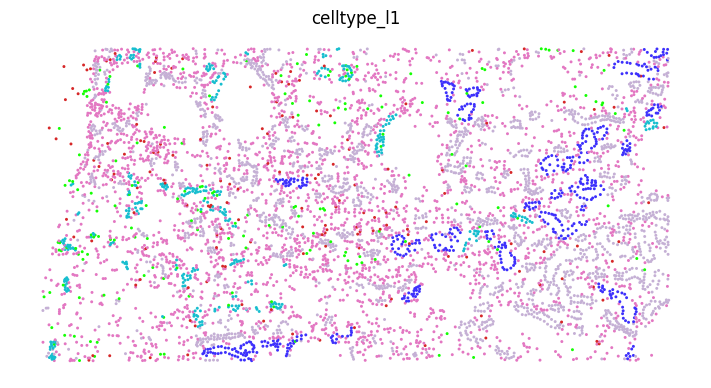

In [169]:
import squidpy as sq
spk='spatial_fov_flat'
key='celltype_l1'
ax = sq.pl.spatial_scatter(adata[adata.obs['fov'].isin([152, 153, 154, 155, 144, 145, 146,147])],groups=['NORN_like','aTAL1_0_like','Fibroblast','LOH','PT','DCT/CNT'],legend_loc=None,color=key, spatial_key=spk,frameon=False, img=False, size=40, return_ax=True)
ax.figure.savefig(f"figs/spatial_full_{key}_sample_UUO2.png", dpi=400, bbox_inches="tight")